# **THESEUS**
## **INFERENCE**

In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import os
import gc
import time
from IPython.display import Markdown


# **CONFIGURATION**

In [24]:
ROOT            = "/kaggle/input/home-credit-credit-risk-model-stability"

In [25]:

CONFIG_LIBRARY={

    1 :  {    "id": 1,
    "type":"LGBMClassifier",
    "parent": 0, # 0 means metamodel
    "children": None, 
    "parameters" : {},
    "make_data_func": "make_data_for_model1",
    "fit_func": "kfold_lightgbm_sklearn"
    
    
},
    
    2: {
    "id": 2,
    "type":"CatBoost",
    "parent": 0,
    "children" : None,
    "parameters" : {},
    "make_data_func": "make_data_for_model2",
    "fit_func": "kfold_catboost_sklearn"
}
,

    
  
    
    0: {
    "id": 0,
    "type" : "Ensemble (LGBMClassifier, CatBoost)",
    "parent": None,
    "children" : [1,2],
    "parameters" : {},
    "make_data_func": "prepare_for_metamodel",
    "fit_func": "simple_average"
    
},
    
    
    
}
    


In [26]:


class Model:
    def __init__ (self, init_id):
        
        if init_id==0:
            print("MODEL ", init_id, " is being initialized")
        else:
            print("\tMODEL ", init_id, " is being initialized")
        if init_id not in CONFIG_LIBRARY:
            raise ValueError("Invalid input Type - class Model initialization")
        
          
        self.definition=CONFIG_LIBRARY[init_id]    

        self.state=0 
        # 0=initialized
        # 1,  for base models: fitted; for ensembles: created oof predictions
       
        self.id=init_id
        self.model_children=[]
        
        if self.definition['children'] is not None:
            print("model ", init_id, " has children ",self.definition['children'])
            for i in self.definition['children']:
             
                if i not in CONFIG_LIBRARY:
                    raise ValueError("Invalid input Type - class Model initialization")
                
                self.model_children.append(Model(i))
                
        if init_id==0:
            print("MODEL ", init_id, " has been initialized")      
        else:
            print("\tMODEL ", init_id, " has been initialized")     
       
        
        
    def train(self):

        variable = "Function train has started - model " + str(self.id) 

# Use string formatting or f-strings to incorporate the variable
        display(Markdown("### **{}**".format(variable)))
        if self.model_children:
            for child in self.model_children:
                child.train()
            print("All submodels of model ", self.id, " have been trained")
        
       
        self.path_input=self.make_data()
        self.fit(self.path_input)
        self.path_output=self.make_prediction(self.path_input)
        
        
        
        variable = "Function train has finished - model " + str(self.id) 

# Use string formatting or f-strings to incorporate the variable
        display(Markdown("### **{}**".format(variable)))
        
    def make_data(self):
        variable = "Function make_data has started - model " + str(self.id) 

# Use string formatting or f-strings to incorporate the variable
        display(Markdown("### **{}**".format(variable)))
        func = globals().get(self.definition["make_data_func"])
        if func is not None and callable(func):
            
            path=func()
        else:
            raise ValueError("Invalid input Type - make data function")
            
        
        variable = "Function make_data has finished - model " + str(self.id) 

# Use string formatting or f-strings to incorporate the variable
        display(Markdown("### **{}**".format(variable)))
        return path
    
    
    def fit(self, path):
        
        
        
        variable = "Function fit has started - model " + str(self.id) 

# Use string formatting or f-strings to incorporate the variable
        display(Markdown("### **{}**".format(variable)))
        func = globals().get(self.definition["fit_func"])
        if func is not None and callable(func):
            self.estimators=[]
            #self.estimators
            self.model, self.oof_preds=func(path)
            
            
            
        else:
            raise ValueError("Invalid input Type - fit function") 

     
            
       
        variable = "Function fit has finished - model " + str(self.id) 

# Use string formatting or f-strings to incorporate the variable
        display(Markdown("### **{}**".format(variable)))
        
        
    def make_prediction(self, path):
        
        
        variable = "Function make_prediction has started - model " + str(self.id) 

# Use string formatting or f-strings to incorporate the variable
        display(Markdown("### **{}**".format(variable)))
        data = pd.read_parquet(path) 
        
        print("shape1: ", data.shape)
        
        target_series = data['target']

        # Check for NaN values
        nan_values = target_series.isna().sum()
        print("Number of NaN values:", nan_values)

        # Get value counts
        value_counts = target_series.value_counts()
        print("Value counts:")
        print(value_counts)
        
        
        for col in data.select_dtypes(exclude=['number','bool']).columns:
            data[col] = data[col].astype('category')
        print("shape2: ", data.shape)
        data_target = data[['case_id', 'WEEK_NUM', 'target']]
        data.drop(data[data['target'].notna()].index, inplace=True)
        print("shape3: ", data.shape)
        target_series = data['target']

        # Check for NaN values
        nan_values = target_series.isna().sum()
        print("Number of NaN values:", nan_values)

        # Get value counts
        value_counts = target_series.value_counts()
        print("Value counts:")
        print(value_counts)
        case_ids=data['case_id'].copy()
        data.drop(columns=['case_id', 'WEEK_NUM', 'target'], inplace=True)
        print("shape4: ", data.shape)
       

        # Check for NaN values
        print(self.model.predict_proba(data)[:,1].shape)
        y_preds=pd.Series(self.model.predict_proba(data)[:,1], index=case_ids)
        
        print(y_preds.head())
        
        #oof_preds_df=pd.DataFrame({str("model"+str(self.id)): y_preds})
        
        output = pd.DataFrame({str("preds"): y_preds.values, 'case_id': case_ids.values})
        
        concatenated_df = pd.concat([self.oof_preds, output], axis=0)
        merged_df = pd.merge(concatenated_df, data_target, on="case_id")
        print("oof_preds shape", self.oof_preds.shape)
        print("output shape", output.shape)
        print("concatenated_dfshape", concatenated_df.shape)
        print("merged shape", merged_df.shape)
        
  
        
        print(output.head())
        path_output=str("/kaggle/working/output"+str(self.id)+".parquet")
        merged_df.to_parquet(path_output)
        
        print("Gini stability - model ", self.id, "is ", gini_stability(path_output))
        
        if self.id==0:
            ROOT = '/kaggle/input/home-credit-credit-risk-model-stability'
            df_subm = pd.read_csv(str(ROOT + "/sample_submission.csv"))
            df_merged = pd.merge(df_subm, output[['preds', 'case_id']], on='case_id', how='left')
            df_merged.drop('score', axis=1, inplace=True)
            df_merged.rename(columns={'preds': 'score'}, inplace=True)
            

        
            
           
         
            df_merged.to_csv("submission.csv")
            
            
            
        variable = "Function make_prediction has finished - model " + str(self.id) 

# Use string formatting or f-strings to incorporate the variable
        display(Markdown("### **{}**".format(variable)))
        
        return path_output
        
    
    
    def predict_proba(self, X):
        return self.model.predict_proba(X)
        
        '''
    def predict(self):
        
    
        
    def set_oof_predictions(self, series):
        
    def get_oof_predictions(self, series):
        
    def stack(self):
    '''
    


## Initialization

In [27]:
def initialization():
    
    display(Markdown("## **function initialization has started**"))
    if not check_validity():
        raise ValueError("Invalid input Type - model configuration")
    metamodel=Model(0)
   
    display(Markdown("## **function initialization has successfully finished**"))
    print()
 
    return metamodel

In [28]:
from contextlib import contextmanager
@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(name, time.time() - t0))

## **CUSTOM FUNCTIONS**

## make_data_for_model1()

In [29]:
import sys
from pathlib import Path
import subprocess
import os
import gc
from glob import glob

import numpy as np
import pandas as pd
import polars as pl
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

ROOT = '/kaggle/input/home-credit-credit-risk-model-stability'



from sklearn.model_selection import TimeSeriesSplit, GroupKFold, StratifiedGroupKFold
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer

class Pipeline:

    def set_table_dtypes(df):
        for col in df.columns:
            if col in ["case_id", "WEEK_NUM", "num_group1", "num_group2"]:
                df = df.with_columns(pl.col(col).cast(pl.Int64))
            elif col in ["date_decision"]:
                df = df.with_columns(pl.col(col).cast(pl.Date))
            elif col[-1] in ("P", "A"):
                df = df.with_columns(pl.col(col).cast(pl.Float64))
            elif col[-1] in ("M",):
                df = df.with_columns(pl.col(col).cast(pl.String))
            elif col[-1] in ("D",):
                df = df.with_columns(pl.col(col).cast(pl.Date))
        return df

    def handle_dates(df):
        for col in df.columns:
            if col[-1] in ("D",):
                df = df.with_columns(pl.col(col) - pl.col("date_decision"))  #!!?
                df = df.with_columns(pl.col(col).dt.total_days()) # t - t-1
        df = df.drop("date_decision", "MONTH")
        return df

    def filter_cols(df):
        for col in df.columns:
            if col not in ["target", "case_id", "WEEK_NUM"]:
                isnull = df[col].is_null().mean()
                if isnull > 0.7:
                    df = df.drop(col)
        
        for col in df.columns:
            if (col not in ["target", "case_id", "WEEK_NUM"]) & (df[col].dtype == pl.String):
                freq = df[col].n_unique()
                if (freq == 1) | (freq > 200):
                    df = df.drop(col)
        
        return df


class Aggregator:
    #Please add or subtract features yourself, be aware that too many features will take up too much space.
    def num_expr(df):
        cols = [col for col in df.columns if col[-1] in ("P", "A")]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        #expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        expr_mean = [pl.mean(col).alias(f"mean_{col}") for col in cols]
        return expr_max +expr_last+expr_mean
    
    def date_expr(df):
        cols = [col for col in df.columns if col[-1] in ("D")]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        #expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        #expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        expr_mean = [pl.mean(col).alias(f"mean_{col}") for col in cols]
        return  expr_max +expr_last+expr_mean
    
    def str_expr(df):
        cols = [col for col in df.columns if col[-1] in ("M",)]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        #expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        #expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        #expr_count = [pl.count(col).alias(f"count_{col}") for col in cols]
        return  expr_max +expr_last#+expr_count
    
    def other_expr(df):
        cols = [col for col in df.columns if col[-1] in ("T", "L")]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        #expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        #expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        return  expr_max +expr_last
    
    def count_expr(df):
        cols = [col for col in df.columns if "num_group" in col]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols] 
        #expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        #expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        return  expr_max +expr_last
    
    def get_exprs(df):
        exprs = Aggregator.num_expr(df) + \
                Aggregator.date_expr(df) + \
                Aggregator.str_expr(df) + \
                Aggregator.other_expr(df) + \
                Aggregator.count_expr(df)

        return exprs

def read_file(path, depth=None):
    df = pl.read_parquet(path)
    df = df.pipe(Pipeline.set_table_dtypes)
    if depth in [1,2]:
        df = df.group_by("case_id").agg(Aggregator.get_exprs(df)) 
    return df

def read_files(regex_path, depth=None):
    chunks = []
    
    for path in glob(str(regex_path)):
        df = pl.read_parquet(path)
        df = df.pipe(Pipeline.set_table_dtypes)
        if depth in [1, 2]:
            df = df.group_by("case_id").agg(Aggregator.get_exprs(df))
        chunks.append(df)
    
    df = pl.concat(chunks, how="vertical_relaxed")
    df = df.unique(subset=["case_id"])
    return df

def feature_eng(df_base, depth_0, depth_1, depth_2):
    df_base = (
        df_base
        .with_columns(
            month_decision = pl.col("date_decision").dt.month(),
            weekday_decision = pl.col("date_decision").dt.weekday(),
        )
    )
    for i, df in enumerate(depth_0 + depth_1 + depth_2):
        df_base = df_base.join(df, how="left", on="case_id", suffix=f"_{i}")
    df_base = df_base.pipe(Pipeline.handle_dates)
    return df_base

def to_pandas(df_data, cat_cols=None):
    df_data = df_data.to_pandas()
    if cat_cols is None:
        cat_cols = list(df_data.select_dtypes("object").columns)
    df_data[cat_cols] = df_data[cat_cols].astype("category")
    return df_data, cat_cols

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        if str(col_type)=="category":
            continue
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            continue
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

ROOT            = Path("/kaggle/input/home-credit-credit-risk-model-stability")

TRAIN_DIR       = ROOT / "parquet_files" / "train"
TEST_DIR        = ROOT / "parquet_files" / "test"



In [30]:

def make_data_for_model1():
    print("make_data_for_model1 started")
  
    
  
    data_store = {
        "df_base": read_file(TRAIN_DIR / "train_base.parquet"),
        "depth_0": [
            read_file(TRAIN_DIR / "train_static_cb_0.parquet"),
            read_files(TRAIN_DIR / "train_static_0_*.parquet"),
        ],
        "depth_1": [
            read_files(TRAIN_DIR / "train_applprev_1_*.parquet", 1),
            read_file(TRAIN_DIR / "train_tax_registry_a_1.parquet", 1),
            read_file(TRAIN_DIR / "train_tax_registry_b_1.parquet", 1),
            read_file(TRAIN_DIR / "train_tax_registry_c_1.parquet", 1),
            read_files(TRAIN_DIR / "train_credit_bureau_a_1_*.parquet", 1),
            read_file(TRAIN_DIR / "train_credit_bureau_b_1.parquet", 1),
            read_file(TRAIN_DIR / "train_other_1.parquet", 1),
            read_file(TRAIN_DIR / "train_person_1.parquet", 1),
            read_file(TRAIN_DIR / "train_deposit_1.parquet", 1),
            read_file(TRAIN_DIR / "train_debitcard_1.parquet", 1),
        ],
        "depth_2": [
            read_file(TRAIN_DIR / "train_credit_bureau_b_2.parquet", 2),
            read_files(TRAIN_DIR / "train_credit_bureau_a_2_*.parquet", 2),
            read_file(TRAIN_DIR / "train_applprev_2.parquet", 2),
            read_file(TRAIN_DIR / "train_person_2.parquet", 2)
        ]
    }

  
    df_train = feature_eng(**data_store)
    print("train data shape:\t", df_train.shape)
    del data_store
    gc.collect()
    df_train = df_train.pipe(Pipeline.filter_cols)
    df_train, cat_cols = to_pandas(df_train)
    
    
    #if 'credtype_322L' in df_train.columns:
    #   CAT_COLS.append('credtype_322L')
    #  df_train['credtype_322L']=df_train['credtype_322L'].astype("category")
    
    df_train = reduce_mem_usage(df_train)
    print("train data shape:\t", df_train.shape)
    nums=df_train.select_dtypes(exclude='category').columns
    from itertools import combinations, permutations
    #df_train=df_train[nums]
    nans_df = df_train[nums].isna()
    nans_groups={}
    for col in nums:
        cur_group = nans_df[col].sum()
        try:
            nans_groups[cur_group].append(col)
        except:
            nans_groups[cur_group]=[col]
    del nans_df; x=gc.collect()

    def reduce_group(grps):
        use = []
        for g in grps:
            mx = 0; vx = g[0]
            for gg in g:
                n = df_train[gg].nunique()
                if n>mx:
                    mx = n
                    vx = gg
                #print(str(gg)+'-'+str(n),', ',end='')
            use.append(vx)
            #print()
        print('Use these',use)
        return use

    def group_columns_by_correlation(matrix, threshold=0.8):
        # 计算列之间的相关性
        correlation_matrix = matrix.corr()

        # 分组列
        groups = []
        remaining_cols = list(matrix.columns)
        while remaining_cols:
            col = remaining_cols.pop(0)
            group = [col]
            correlated_cols = [col]
            for c in remaining_cols:
                if correlation_matrix.loc[col, c] >= threshold:
                    group.append(c)
                    correlated_cols.append(c)
            groups.append(group)
            remaining_cols = [c for c in remaining_cols if c not in correlated_cols]

        return groups

    uses=[]
    for k,v in nans_groups.items():
        if len(v)>1:
                Vs = nans_groups[k]
                #cross_features=list(combinations(Vs, 2))
                #make_corr(Vs)
                grps= group_columns_by_correlation(df_train[Vs], threshold=0.8)
                use=reduce_group(grps)
                uses=uses+use
                #make_corr(use)
        else:
            uses=uses+v
        print('####### NAN count =',k)
    print(uses)
    print(len(uses))
    uses=uses+list(df_train.select_dtypes(include='category').columns)
    print(len(uses))
    df_train=df_train[uses]
    
    
    sample = pd.read_csv("/kaggle/input/home-credit-credit-risk-model-stability/sample_submission.csv")
    device='gpu'
    #n_samples=200000
    n_est=6000
    DRY_RUN = True if sample.shape[0] == 10 else False   
    if DRY_RUN:
        device='cpu'
        df_train = df_train.iloc[:50000]
        #n_samples=10000
        n_est=600
    print(device)  
    
    
    data_store = {
    "df_base": read_file(TEST_DIR / "test_base.parquet"),
    "depth_0": [
        read_file(TEST_DIR / "test_static_cb_0.parquet"),
        read_files(TEST_DIR / "test_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TEST_DIR / "test_applprev_1_*.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_a_1.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_b_1.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_c_1.parquet", 1),
        read_files(TEST_DIR / "test_credit_bureau_a_1_*.parquet", 1),
        read_file(TEST_DIR / "test_credit_bureau_b_1.parquet", 1),
        read_file(TEST_DIR / "test_other_1.parquet", 1),
        read_file(TEST_DIR / "test_person_1.parquet", 1),
        read_file(TEST_DIR / "test_deposit_1.parquet", 1),
        read_file(TEST_DIR / "test_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TEST_DIR / "test_credit_bureau_b_2.parquet", 2),
        read_files(TEST_DIR / "test_credit_bureau_a_2_*.parquet", 2),
        read_file(TEST_DIR / "test_applprev_2.parquet", 2),
        read_file(TEST_DIR / "test_person_2.parquet", 2)
    ]
}
    df_test = feature_eng(**data_store)
    print("test data shape:\t", df_test.shape)
    del data_store
    gc.collect()
    df_test = df_test.select([col for col in df_train.columns if col != "target"])
    print("train data shape:\t", df_train.shape)
    print("test data shape:\t", df_test.shape)

    df_test, cat_cols = to_pandas(df_test, cat_cols)
    df_test = reduce_mem_usage(df_test)

    gc.collect()
    
    
    df_test['target'] = None
    df_train.sort_index(axis=1, inplace=True)
    df_test.sort_index(axis=1, inplace=True)
    print("train data shape:\t", df_train.shape)
    print("test data shape:\t", df_test.shape)
    df=pd.concat([df_train, df_test])
    df.reset_index(drop=True, inplace=True)
    del df_train;del df_test;gc.collect()
    print("combined data shape:\t", df.shape)

    
    
    
    path = "/kaggle/working/input1.parquet"
    
    
    
    if all(col in df.columns for col in ['target', 'case_id', 'WEEK_NUM']):
        # Check if target column values are restricted to 1, 0, or NaN
        

        # Check if case_id has unique values
        case_id_unique = df['case_id'].is_unique

        # Check if case_id and WEEK_NUM don't contain NaN values
        case_id_week_num_no_nan = df[['case_id', 'WEEK_NUM']].notna().all().all()

        # If all conditions are met, print the statement
        if case_id_unique and case_id_week_num_no_nan:
            print("target, case_id, and WEEK_NUM are present and properly formatted")
        else:
            print("Conditions are not met.")
        
          
    else:
        print("Columns target, case_id, or WEEK_NUM are missing.")
        
        
    if 'target' in df.columns:
    # Print the value counts of 'target' column, including NaN values
        print(df['target'].value_counts(dropna=False))
    else:
        print("Column 'target' is missing.")
        
    columns_to_exclude = ['target', 'case_id', 'WEEK_NUM']

# Filter out the columns to count
    columns_to_count = [col for col in df.columns if col not in columns_to_exclude]

    # Count the remaining columns
    column_count = len(columns_to_count)

    # Print the count
    print("Number of columns (excluding 'target', 'case_id', and 'WEEK_NUM'): ", column_count)
    
    row_count = df.shape[0]

# Print the count
    print("Number of rows:", row_count)
    # Export DataFrame to Parquet
    df.to_parquet(path)
    
    print("make_data_for_model1 ended")
    return path
    
    
    


## make_data_for_model2()

In [31]:
def make_data_for_model2():
    
    print("make_data_for_model2 started")
    path = "/kaggle/working/input1.parquet"
    print("make_data_for_model2 ended")
    return path

## kfold_lightgbm_sklearn()

In [32]:

class VotingModelLGBM(BaseEstimator, RegressorMixin):
        def __init__(self, estimators):
            super().__init__()
            self.estimators = estimators
            

        def fit(self, X, y=None):
            return self

        def predict(self, X):
            y_preds = [estimator.predict(X) for estimator in self.estimators]
            return np.mean(y_preds, axis=0)

        def predict_proba(self, X):

            dtype_counts = X.dtypes.value_counts()
            print("Value counts of data types:")
            print(dtype_counts)

            




            X_object_columns = list(X.select_dtypes("object").columns)



            X[X_object_columns] = X[X_object_columns].astype('category')
            cat_cols = list(X.select_dtypes("category").columns)

            dtype_counts = X.dtypes.value_counts()

            print("Value counts of data types:")
            print(dtype_counts)
            
            
            X.sort_index(axis=1, inplace=True)
            y_preds = [estimator.predict_proba(X) for estimator in self.estimators]

            return np.mean(y_preds, axis=0)

def kfold_lightgbm_sklearn(path):
    
    
    
     
    
    
    
    
    
    
    
    
    
    

    df_train=pd.read_parquet(path)
    
    
    dtype_counts = df_train.dtypes.value_counts()
    print("Value counts of data types:")
    print(dtype_counts)
    
    df_train.drop(df_train[df_train['target'].isnull()].index, inplace=True)
    
    
    
    
    df_train_object_columns = list(df_train.select_dtypes("object").columns)
    

   
    df_train[df_train_object_columns] = df_train[df_train_object_columns].astype('category')
    cat_cols = list(df_train.select_dtypes("category").columns)
    
    dtype_counts = df_train.dtypes.value_counts()

    print("Value counts of data types:")
    print(dtype_counts)

    # Extract category columns into a list
    
    
    
    
    
    
    
    
   
    df_train=df_train[:50000]

    
    
    y = df_train["target"]
    weeks = df_train["WEEK_NUM"]
    data_target=df_train['target']
    data_case_id=df_train['case_id']
    df_train= df_train.drop(columns=["target", "case_id", "WEEK_NUM"])
    cv = StratifiedGroupKFold(n_splits=5, shuffle=False)
    
    
    

   


    sample = pd.read_csv("/kaggle/input/home-credit-credit-risk-model-stability/sample_submission.csv")
    device='gpu'
    #n_samples=200000
    n_est=6000
    DRY_RUN = True if sample.shape[0] == 10 else False   
    if DRY_RUN:
        device='cpu'
        df_train = df_train.iloc[:50000]
        #n_samples=10000
        n_est=600
    print(device)

    params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 10,  
    "learning_rate": 0.05,
    "n_estimators": 2000,  
    "colsample_bytree": 0.8,
    "colsample_bynode": 0.8,
    "verbose": -1,
    "random_state": 42,
    "reg_alpha": 0.1,
    "reg_lambda": 10,
    "extra_trees":True,
    'num_leaves':64,
    "device": device, 
    "verbose": -1,
}
    
    
  
  

  
    fitted_models_lgb = []

  
    cv_scores_lgb = []
    oof_preds = np.zeros(df_train.shape[0])

    for idx_train, idx_valid in cv.split(df_train, y, groups=weeks):#
        X_train, y_train = df_train.iloc[idx_train], y.iloc[idx_train]# 
        X_valid, y_valid = df_train.iloc[idx_valid], y.iloc[idx_valid]
        
        
       
        X_train.sort_index(axis=1, inplace=True)
        X_valid.sort_index(axis=1, inplace=True)


        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_train, y_train,
            eval_set = [(X_valid, y_valid)],
            callbacks = [lgb.log_evaluation(200), lgb.early_stopping(100)] )

        fitted_models_lgb.append(model)
        y_pred_valid = model.predict_proba(X_valid)[:,1]
        oof_preds[idx_valid]=y_pred_valid
        auc_score = roc_auc_score(y_valid, y_pred_valid)
        cv_scores_lgb.append(auc_score)


 
    print('Full AUC score %.6f' % roc_auc_score(data_target, oof_preds))
    print("CV AUC scores: ", cv_scores_lgb)
    print("Maximum CV AUC score: ", max(cv_scores_lgb))
    
    model = VotingModelLGBM(fitted_models_lgb)
    
    oof_df = pd.DataFrame({'preds': pd.Series(oof_preds), 'case_id': data_case_id})

    return model, oof_df

## kfold_catboost_sklearn(path)

In [33]:
def kfold_catboost_sklearn(path):
    
    

    

   

    df_train=pd.read_parquet(path)
    
    
    dtype_counts = df_train.dtypes.value_counts()
    print("Value counts of data types:")
    print(dtype_counts)
    
    df_train.drop(df_train[df_train['target'].isnull()].index, inplace=True)
    
    
    
    
    df_train_object_columns = list(df_train.select_dtypes("object").columns)
    

   
    df_train[df_train_object_columns] = df_train[df_train_object_columns].astype('category')
    cat_cols = list(df_train.select_dtypes("category").columns)
    
    dtype_counts = df_train.dtypes.value_counts()

    print("Value counts of data types:")
    print(dtype_counts)

    # Extract category columns into a list
    
    
    
    
    class VotingModelCatBoost(BaseEstimator, RegressorMixin):
        def __init__(self, estimators, cat_cols):
            super().__init__()
            self.estimators = estimators
            self.cat_cols=cat_cols
            

        def fit(self, X, y=None):
            return self

        def predict(self, X):
            y_preds = [estimator.predict(X) for estimator in self.estimators]
            return np.mean(y_preds, axis=0)

        def predict_proba(self, X):

            
            dtype_counts = X.dtypes.value_counts()
            print("Value counts of data types:")
            print(dtype_counts)

            




            X_object_columns = list(X.select_dtypes("object").columns)



            X[X_object_columns] = X[X_object_columns].astype('category')
            

            dtype_counts = X.dtypes.value_counts()

            print("Value counts of data types:")
            print(dtype_counts)
# Extract category columns into a list
            X[self.cat_cols]=X[self.cat_cols].astype(str)
            X.sort_index(axis=1, inplace=True)
            y_preds = [estimator.predict_proba(X) for estimator in self.estimators]

            return np.mean(y_preds, axis=0)
    
    
    
    
    sample = pd.read_csv("/kaggle/input/home-credit-credit-risk-model-stability/sample_submission.csv")
    device='GPU'
    #n_samples=200000
    n_est=6000
    DRY_RUN = True if sample.shape[0] == 10 else False   
    if DRY_RUN:
        device='CPU'
        df_train = df_train.iloc[:50000]
        n_samples=10000
        n_est=600
    
    #df_train=df_train[:11111]
    
    dtype_counts = df_train.dtypes.value_counts()

    print("Value counts of data types:")
    print(dtype_counts)
    
    
    data_target=df_train['target']
    data_case_id=df_train['case_id']
    
    y = df_train["target"]
    weeks = df_train["WEEK_NUM"]
    df_train= df_train.drop(columns=["target", "case_id", "WEEK_NUM"])
    cv = StratifiedGroupKFold(n_splits=5, shuffle=False)
    
    df_train[cat_cols] = df_train[cat_cols].astype(str)
 
    
    from catboost import CatBoostClassifier, Pool

    fitted_models_cat = []
   

    cv_scores_cat = []
   
    oof_preds = np.zeros(df_train.shape[0])

    print("credtype_322L summary")
    print(df_train['credtype_322L'].dtype)
    print(df_train['credtype_322L'].value_counts())

    for idx_train, idx_valid in cv.split(df_train, y, groups=weeks):#
        X_train, y_train = df_train.iloc[idx_train], y.iloc[idx_train]# 
        X_valid, y_valid = df_train.iloc[idx_valid], y.iloc[idx_valid]
        
        X_train.sort_index(axis=1, inplace=True)
        X_valid.sort_index(axis=1, inplace=True)
        
        
        
        train_pool = Pool(X_train, y_train,cat_features=cat_cols)
        val_pool = Pool(X_valid, y_valid,cat_features=cat_cols)
        clf = CatBoostClassifier(
        eval_metric='AUC',
        task_type=device,
        learning_rate=0.03,
        iterations=n_est)
        random_seed=3107
        clf.fit(train_pool, eval_set=val_pool,verbose=300)
        fitted_models_cat.append(clf)
        y_pred_valid = clf.predict_proba(X_valid)[:,1]
        oof_preds[idx_valid]=y_pred_valid
        auc_score = roc_auc_score(y_valid, y_pred_valid)
        cv_scores_cat.append(auc_score)


      
    
    print('Full AUC score %.6f' % roc_auc_score(data_target, oof_preds))
    print("CV AUC scores: ", cv_scores_cat)
    print("Maximum CV AUC score: ", max(cv_scores_cat))

    model = VotingModelCatBoost(fitted_models_cat, cat_cols)
    
    oof_df = pd.DataFrame({'preds': pd.Series(oof_preds), 'case_id': data_case_id})
    
    return model, oof_df

## prepare_for_metamodel():

In [34]:
def prepare_for_metamodel():
    
    
    
    df1=pd.read_parquet("/kaggle/working/output1.parquet")
    df2=pd.read_parquet("/kaggle/working/output2.parquet")
   
    #df1.reset_index(inplace=True)
# Check if the "target" column is the same for both DataFrames based on their indexes
    # Sort both dataframes by the "case_id" column
    df1_sorted = df1.sort_values(by="case_id")
    df2_sorted = df2.sort_values(by="case_id")

    # Check if the values and order are the same
# Check if the "case_id" columns are equal
    if df1_sorted["case_id"].equals(df2_sorted["case_id"]):
        print("The 'case_id' columns have the same values and order in both dataframes.")
    else:
        print("The 'case_id' columns have different values and/or order in the dataframes.")
        
  
    
    print(df1.columns)
    print(df2.columns)
    
    merged_df = pd.merge(df1, df2, on='case_id', suffixes=('_df1', '_df2'))
    print("merged columns ", merged_df.columns)
# Drop duplicate columns for "target", "WEEK_NUM", and "case_id"
    merged_df.drop(['target_df2', 'WEEK_NUM_df2'], axis=1, inplace=True)
    print("here 1 shape ", merged_df.shape)
    # Rename columns to remove the suffix for the second preds column
    merged_df.rename(columns={'WEEK_NUM_df1':'WEEK_NUM','target_df1': 'target', 'preds_df1': 'preds1','preds_df2': 'preds2'}, inplace=True)
    
    print("here 2 shape ", merged_df.shape)
    # Print the merged DataFrame
    print(merged_df)
    
    merged_df.to_parquet("/kaggle/working/input0.parquet")
    
    data=merged_df
    
    if all(col in data.columns for col in ['target', 'case_id', 'WEEK_NUM']):
        # Check if target column values are restricted to 1, 0, or NaN
        

        # Check if case_id has unique values
        case_id_unique = data['case_id'].is_unique

        # Check if case_id and WEEK_NUM don't contain NaN values
        case_id_week_num_no_nan = data[['case_id', 'WEEK_NUM']].notna().all().all()

        # If all conditions are met, print the statement
        if case_id_unique and case_id_week_num_no_nan:
            print("target, case_id, and WEEK_NUM are present and properly formatted")
        else:
            print("Conditions are not met.")
        
          
    else:
        print("Columns target, case_id, or WEEK_NUM are missing.")
        
        
    if 'target' in data.columns:
    # Print the value counts of 'target' column, including NaN values
        print(data['target'].value_counts(dropna=False))
    else:
        print("Column 'target' is missing.")
        
    columns_to_exclude = ['target', 'case_id', 'WEEK_NUM']

# Filter out the columns to count
    columns_to_count = [col for col in data.columns if col not in columns_to_exclude]

    # Count the remaining columns
    column_count = len(columns_to_count)

    # Print the count
    print("Number of columns (excluding 'target', 'case_id', and 'WEEK_NUM'): ", column_count)
    
    row_count = data.shape[0]

# Print the count
    print("Number of rows:", row_count)    
    
    
    
    
    return "/kaggle/working/input0.parquet"

## simple_average(path):

In [35]:
def simple_average(path):
    
    
    class Average:
        def __init__(self):
            super().__init__()
        #self.estimators = estimators
        
        
        def fit(self, X, y=None):
            return self

        def predict(self, X):
            # Check if X is a pandas DataFrame with 2 numerical columns
            if not isinstance(X, pd.DataFrame):
                raise ValueError("X must be a pandas DataFrame")
            if len(X.columns) != 2:
                raise ValueError("X must have exactly 2 columns")
            if not all(X.dtypes == 'int64') and not all(X.dtypes == 'float64'):
                raise ValueError("Both columns in X must be numerical")

            # Calculate the mean of each column
            result = X.mean(axis=1)

            # Convert the result to a pandas Series with discrete values (0 or 1)
            result = (result >= 0.5).astype(int)

            return result

        def predict_proba(self, X):
            # Check if X is a pandas DataFrame with 2 numerical columns
            if not isinstance(X, pd.DataFrame):
                raise ValueError("X must be a pandas DataFrame")
            if len(X.columns) != 2:
                raise ValueError("X must have exactly 2 columns")
            if not all(X.dtypes == 'int64') and not all(X.dtypes == 'float64'):
                raise ValueError("Both columns in X must be numerical")

            # Calculate the mean of each column
            result = X.mean(axis=1)

            # Convert the result to a pandas Series
            result1 = pd.Series(result)
            result0= 1 - pd.Series(result)

            return pd.DataFrame({'0': result0, '1': result1}).values
        
    model=Average()
    
    data=pd.read_parquet("/kaggle/working/input0.parquet")
    

    
    data.drop(data[data['target'].isnull()].index, inplace=True)
    target=data['target'].copy()
    
    data.drop(columns=['target','WEEK_NUM'], inplace=True)
    
    print(data)
    oof_preds=model.predict_proba(data.drop(columns=['case_id']))[:,1]
    
    print('Full AUC score %.6f' % roc_auc_score(target, oof_preds))
    plt.figure(figsize=(8, 6))
    plt.hist(oof_preds, bins=30, edgecolor='k', alpha=0.7)
    plt.xlabel('Prediction Probability')
    plt.ylabel('Frequency')
    plt.title('Prediction Probability Histogram')
    plt.grid(True)
    plt.show()
        
    return model, pd.DataFrame({'preds': oof_preds, 'case_id': data['case_id'].values})


# **INFRASTRUCTURE**

### Class Model

In [36]:
from graphviz import Digraph, Source

def visualize_ensemble_structure(config):
    dot = Digraph()

    def add_nodes_edges(node):
        if node["parent"] is None:
            dot.node(str(node["id"]), label=node["type"], shape="box")
        else:
            dot.node(str(node["id"]), label=node["type"])
        if node["children"]:
            for child_id in node["children"]:
                dot.edge(str(node["id"]), str(child_id))
                add_nodes_edges(config[child_id])

    for _, node in config.items():
        add_nodes_edges(node)

    return dot

## gini_stability

In [37]:
def gini_stability(path, w_fallingrate=88.0, w_resstd=-0.5):
    base = pd.read_parquet(path)
    base.drop(base[base['target'].isnull()].index, inplace=True)
    temp = base.loc[:, ["WEEK_NUM", "target", "preds"]] \
               .sort_values("WEEK_NUM") \
               .groupby("WEEK_NUM").mean()

    week_nums_to_drop = temp[(temp["target"] == 0) | (temp["target"] == 1)].index.tolist()
    base_filtered = base[~base["WEEK_NUM"].isin(week_nums_to_drop)]

    # Apply the aggregator
    gini_in_time = base_filtered.loc[:, ["WEEK_NUM", "target", "preds"]] \
                                 .sort_values("WEEK_NUM") \
                                 .groupby("WEEK_NUM")[["target", "preds"]] \
                                 .apply(lambda x: 2 * roc_auc_score(x["target"], x["preds"]) - 1).tolist()

    x = np.arange(len(gini_in_time))
    y = gini_in_time
    a, b = np.polyfit(x, y, 1)
    y_hat = a * x + b
    residuals = y - y_hat
    res_std = np.std(residuals)
    avg_gini = np.nanmean(gini_in_time)  # Use np.nanmean to handle NaN values

    # Display the bar chart with WEEK_NUM on x-axis and the fitted line
    plt.figure(figsize=(8, 6))
    plt.bar(x, y, label='Gini in Time')
    plt.plot(x, y_hat, '-', label='Fitted line (slope={:.2f}, intercept={:.2f})'.format(a, b), color='red')
    plt.xlabel('Week')
    plt.ylabel('Gini in Time')
    plt.title('Gini Stability Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

    return avg_gini + w_fallingrate * min(0, a) + w_resstd * res_std

In [38]:
def check_validity():
    
    if not(all(isinstance(key, int) for key in CONFIG_LIBRARY.keys()) and \
       len(CONFIG_LIBRARY.keys()) == len(set(CONFIG_LIBRARY.keys())) and \
       all(isinstance(value, dict) for value in CONFIG_LIBRARY.values())):
        # Your code here if all conditions are met
  
        return False
    
    
    required_keys = {
    "id", "type", "parent", "children", "parameters", "make_data_func", "fit_func"
}
    

    
    for library in CONFIG_LIBRARY.values():
        if not required_keys.issubset(library.keys()):
        
            return False
        
        
        if  not isinstance(library["id"], int):
            #print("The value associated with the key 'id' is an integer.")
       
            print("The value associated with the key 'id' is either missing or not an integer.")
            return False
        
        if  not isinstance(library["id"], int):
            #print("The value associated with the key 'id' is an integer.")
       
            print("The value associated with the key 'id' is either missing or not an integer.")
            return False
        
        if  not isinstance(library["type"], str):
            #print("The value associated with the key 'id' is an integer.")
        
            print("The value associated with the key 'type' is either missing or not an integer.")
            return False
        

    
    
    return True

In [39]:
class VotingModel():
    def __init__(self, estimators):
        super().__init__()
        self.estimators = estimators
        
        
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        y_preds = [estimator.predict(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)
    
    def predict_proba(self, X):
        
        y_preds = [estimator.predict_proba(X) for estimator in self.estimators]
        
        return np.mean(y_preds, axis=0)

In [40]:
def generate_submission_file(metamodel):
    
    metamodel.make_prediction()
    
    y_preds=metamodel.predict_proba(test_ids)
    

In [41]:
def fit_models(metamodel):
    
    display(Markdown("## **Function fit_models has started**"))
    
    metamodel.train()
    
    display(Markdown("## **Function fit_models has finished**"))
    
   
    
    # iterate through children
    
    
    
    
  

In [42]:
def main(debug=False):
    
    with timer("initialization()"):
        display(Markdown("# **THESEUS has started**"))
        metamodel=initialization()
    # Creates dummy version of the models.
    with timer("fit_models()"):
        metamodel=fit_models(metamodel)
    # It trains models, it goes from apex down to the base models.
    # It creates oof predictions.
    
    #metamodel=ensemble_models(metamodel)
    
    #It sets the blending technique/
    # Now, predict_proba in metamodel is ready to be called.
    display(Markdown("# **THESEUS has successfully finished**"))
    
    

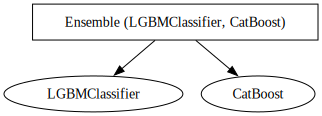

In [43]:
visualize_ensemble_structure(CONFIG_LIBRARY)

# **THESEUS has started**

## **function initialization has started**

MODEL  0  is being initialized
model  0  has children  [1, 2]
	MODEL  1  is being initialized
	MODEL  1  has been initialized
	MODEL  2  is being initialized
	MODEL  2  has been initialized
MODEL  0  has been initialized


## **function initialization has successfully finished**


initialization() - done in 0s


## **Function fit_models has started**

### **Function train has started - model 0**

### **Function train has started - model 1**

### **Function make_data has started - model 1**

make_data_for_model1 started
train data shape:	 (1526659, 861)
Memory usage of dataframe is 4322.75 MB
Memory usage after optimization is: 1528.81 MB
Decreased by 64.6%
train data shape:	 (1526659, 472)
Use these ['case_id', 'WEEK_NUM', 'target', 'month_decision', 'weekday_decision', 'credamount_770A', 'applicationcnt_361L', 'applications30d_658L', 'applicationscnt_1086L', 'applicationscnt_464L', 'applicationscnt_867L', 'clientscnt_1022L', 'clientscnt_100L', 'clientscnt_1071L', 'clientscnt_1130L', 'clientscnt_157L', 'clientscnt_257L', 'clientscnt_304L', 'clientscnt_360L', 'clientscnt_493L', 'clientscnt_533L', 'clientscnt_887L', 'clientscnt_946L', 'deferredmnthsnum_166L', 'disbursedcredamount_1113A', 'downpmt_116A', 'homephncnt_628L', 'isbidproduct_1095L', 'mobilephncnt_593L', 'numactivecreds_622L', 'numactivecredschannel_414L', 'numactiverelcontr_750L', 'numcontrs3months_479L', 'numnotactivated_1143L', 'numpmtchanneldd_318L', 'numrejects9m_859L', 'sellerplacecnt_915L', 'max_mainoccupat

### **Function make_data has finished - model 1**

### **Function fit has started - model 1**

Value counts of data types:
float16     187
object       98
float32      84
category      5
int8          3
category      2
category      2
int32         1
category      1
category      1
category      1
category      1
category      1
float64       1
category      1
Name: count, dtype: int64
Value counts of data types:
float16     187
float32      84
category     19
category      4
category      4
           ... 
category      1
category      1
category      1
category      1
category      1
Name: count, Length: 70, dtype: int64
cpu
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.74029
Early stopping, best iteration is:
[107]	valid_0's auc: 0.742971
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[88]	valid_0's auc: 0.749777
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.785891
Early stopping, best iteration is:
[151]	valid_0's auc: 0.788365
Training until valida

### **Function fit has finished - model 1**

### **Function make_prediction has started - model 1**

shape1:  (50010, 389)
Number of NaN values: 10
Value counts:
target
0.0    48257
1.0     1743
Name: count, dtype: int64
shape2:  (50010, 389)
shape3:  (10, 389)
Number of NaN values: 10
Value counts:
Series([], Name: count, dtype: int64)
shape4:  (10, 386)
Value counts of data types:
float16     187
float32      84
category     15
category      6
category      4
           ... 
category      1
category      1
category      1
category      1
category      1
Name: count, Length: 71, dtype: int64
Value counts of data types:
float16     187
float32      84
category     15
category      6
category      4
           ... 
category      1
category      1
category      1
category      1
category      1
Name: count, Length: 71, dtype: int64
(10,)
Value counts of data types:
float16     187
float32      84
category     15
category      6
category      4
           ... 
category      1
category      1
category      1
category      1
category      1
Name: count, Length: 71, dtype: int64
Value count

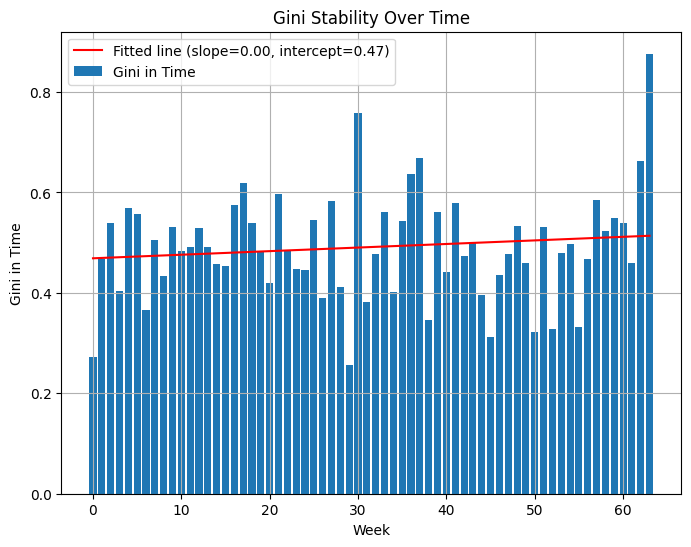

Gini stability - model  1 is  0.4381100785185657


### **Function make_prediction has finished - model 1**

### **Function train has finished - model 1**

### **Function train has started - model 2**

### **Function make_data has started - model 2**

make_data_for_model2 started
make_data_for_model2 ended


### **Function make_data has finished - model 2**

### **Function fit has started - model 2**

Value counts of data types:
float16     187
object       98
float32      84
category      5
int8          3
category      2
category      2
int32         1
category      1
category      1
category      1
category      1
category      1
float64       1
category      1
Name: count, dtype: int64
Value counts of data types:
float16     187
float32      84
category     19
category      4
category      4
           ... 
category      1
category      1
category      1
category      1
category      1
Name: count, Length: 70, dtype: int64
Value counts of data types:
float16     187
float32      84
category     19
category      4
category      4
           ... 
category      1
category      1
category      1
category      1
category      1
Name: count, Length: 70, dtype: int64
credtype_322L summary
object
credtype_322L
CAL    44390
REL     5610
Name: count, dtype: int64
0:	test: 0.5328172	best: 0.5328172 (0)	total: 566ms	remaining: 5m 39s
300:	test: 0.7400536	best: 0.7401114 (293)	total: 2m 30s	

### **Function fit has finished - model 2**

### **Function make_prediction has started - model 2**

shape1:  (50010, 389)
Number of NaN values: 10
Value counts:
target
0.0    48257
1.0     1743
Name: count, dtype: int64
shape2:  (50010, 389)
shape3:  (10, 389)
Number of NaN values: 10
Value counts:
Series([], Name: count, dtype: int64)
shape4:  (10, 386)
Value counts of data types:
float16     187
float32      84
category     15
category      6
category      4
           ... 
category      1
category      1
category      1
category      1
category      1
Name: count, Length: 71, dtype: int64
Value counts of data types:
float16     187
float32      84
category     15
category      6
category      4
           ... 
category      1
category      1
category      1
category      1
category      1
Name: count, Length: 71, dtype: int64
(10,)
Value counts of data types:
float16    187
object     113
float32     84
int8         2
Name: count, dtype: int64
Value counts of data types:
float16     187
float32      84
category     33
category      6
category      4
category      3
category      3

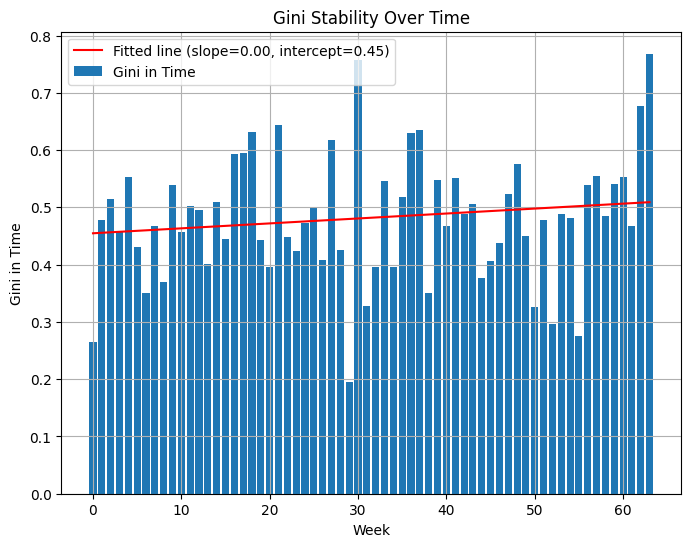

Gini stability - model  2 is  0.42805591724055364


### **Function make_prediction has finished - model 2**

### **Function train has finished - model 2**

All submodels of model  0  have been trained


### **Function make_data has started - model 0**

The 'case_id' columns have the same values and order in both dataframes.
Index(['preds', 'case_id', 'WEEK_NUM', 'target'], dtype='object')
Index(['preds', 'case_id', 'WEEK_NUM', 'target'], dtype='object')
merged columns  Index(['preds_df1', 'case_id', 'WEEK_NUM_df1', 'target_df1', 'preds_df2',
       'WEEK_NUM_df2', 'target_df2'],
      dtype='object')
here 1 shape  (50010, 5)
here 2 shape  (50010, 5)
         preds1  case_id  WEEK_NUM  target    preds2
0      0.043855        0         0     0.0  0.062883
1      0.112229        1         0     0.0  0.068905
2      0.039949        2         0     0.0  0.051945
3      0.060122        3         0     0.0  0.081044
4      0.093392        4         0     1.0  0.077601
...         ...      ...       ...     ...       ...
50005  0.015239    57630       100     NaN  0.027020
50006  0.038572    57631       100     NaN  0.047093
50007  0.035312    57632       100     NaN  0.065273
50008  0.028741    57633       100     NaN  0.020389
50009  0.060

### **Function make_data has finished - model 0**

### **Function fit has started - model 0**

         preds1  case_id    preds2
0      0.043855        0  0.062883
1      0.112229        1  0.068905
2      0.039949        2  0.051945
3      0.060122        3  0.081044
4      0.093392        4  0.077601
...         ...      ...       ...
49995  0.019300    49995  0.031778
49996  0.014855    49996  0.010831
49997  0.117555    49997  0.184740
49998  0.017881    49998  0.029767
49999  0.017243    49999  0.025510

[50000 rows x 3 columns]
Full AUC score 0.754325


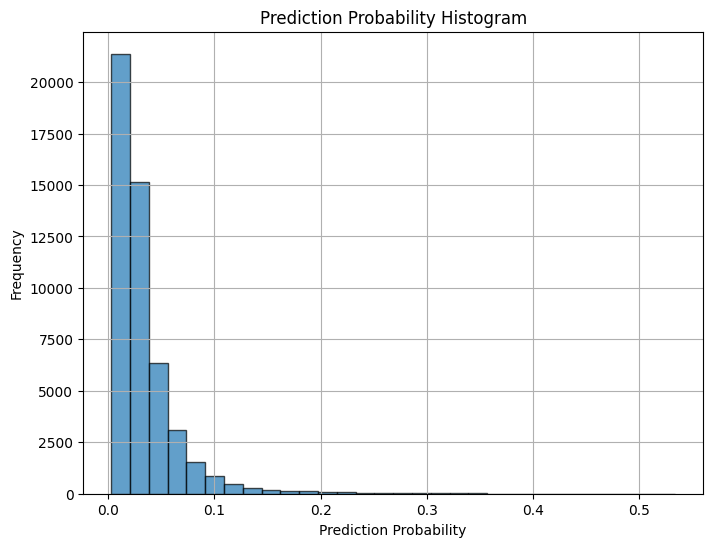

### **Function fit has finished - model 0**

### **Function make_prediction has started - model 0**

shape1:  (50010, 5)
Number of NaN values: 10
Value counts:
target
0.0    48257
1.0     1743
Name: count, dtype: int64
shape2:  (50010, 5)
shape3:  (10, 5)
Number of NaN values: 10
Value counts:
Series([], Name: count, dtype: int64)
shape4:  (10, 2)
(10,)
case_id
57543    0.021100
57549    0.040402
57551    0.018008
57552    0.057600
57569    0.041072
dtype: float64
oof_preds shape (50000, 2)
output shape (10, 2)
concatenated_dfshape (50010, 2)
merged shape (50010, 4)
      preds  case_id
0  0.021100    57543
1  0.040402    57549
2  0.018008    57551
3  0.057600    57552
4  0.041072    57569


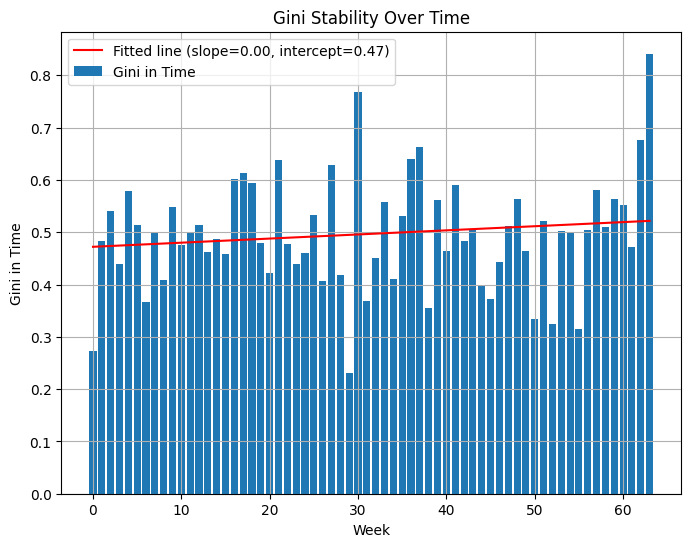

Gini stability - model  0 is  0.4436086246222564


### **Function make_prediction has finished - model 0**

### **Function train has finished - model 0**

## **Function fit_models has finished**

fit_models() - done in 1979s


# **THESEUS has successfully finished**

In [44]:
main()